# Задание - Предсказание уровня экспрессии белка

In [32]:
import pandas as pd
import numpy as np

import networkx as nx
import igraph as ig

import matplotlib.pyplot as plt
import seaborn as sns

#from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error

<img src='https://www.researchgate.net/publication/313504607/figure/fig3/AS:459880453677066@1486655453033/Protein-protein-interaction-PPI-network-of-DEGs-by-STRING-The-interaction-score-was.png'>




<div class="alert alert-info">
<b>Про биологию</b>
    
Экспрессия — процесс, в ходе которого наследственная информация от гена (последовательности нуклеотидов ДНК) преобразуется в функциональный продукт — белок. Уровнем экспрессии называют - количество белка, производящегося в этом процессе. Чем выше экспрессия белка, тем большее количество этого белка появляется в клетках человека. 
    
    

<div class="alert alert-info">    
<b>Важность задачи</b>
    
Существует множество причин необходимости в знании уровня экспресии белка. Например - это позволяет ученым разрабатывать лекарственные средства и оптимизировать их разработку. Теперь вам предстоит побыть в роли биоинформатика и помочь науке!
    
</div>


<div class="alert alert-info">
<b>Про Датасет</b>
    
Датасет представляет собой граф взаимойдествия белков. Где узлы это белки, взаимодействие между белками это ребро. 

Для каждого белка известен уровень его экспрессии. Ниже приведен список ребер `edges`. Информация по экспрессии белков, разбитая на `train` и `test`.
   
    
</div>

In [33]:
#Список ребер графа 

edges = pd.read_csv("https://raw.githubusercontent.com/a-milenkin/Otus_HW_protein_expression/main/edges.csv", sep=",") # Подгрузим данные
edges.head()

,node_1,node_2
0,344,50
1,344,153
2,344,532
3,344,679
4,344,986


In [34]:
#Подгрузим тренирочную выборку
train = pd.read_csv("https://raw.githubusercontent.com/a-milenkin/Otus_HW_protein_expression/main/train.csv", sep=",") # Подгрузим данные
train.head()

,target,node
0,0.251968,11142
1,0.689541,2243
2,0.678245,15514
3,0.272500,20944
4,0.248888,8721


In [35]:
# Подгрузим отложенную выборку для валидации
test = pd.read_csv("https://raw.githubusercontent.com/a-milenkin/Otus_HW_protein_expression/main/test.csv", sep=",")
test.head()

,target,node
0,0.279231,817
1,0.380795,9574
2,0.686527,1607
3,0.303594,4782
4,0.367374,24125


<div class="alert alert-info">
<b>Про Задачу</b>
    
Вам предлагается предсказать экспрессию белков (`target`) по приведенным данным для отложенной выборки. Ответы в отложенной выборке `test` даны вам для самостоятельной валидации.


    
   
    

<div class="alert alert-info">
<b>Замечание и комментарии</b>
    
    

По ряду причин датасет был упрощен так, чтобы выполнялись следующие условия:
* у графа одна компонента связанности. 
* удалены слишком крупные хабы
* плотность связей графа уменьшена
* решить задачу можно классическими ML подходами
    
   

<div class="alert alert-info">
<b>Оценка результатов</b>
    


Оценка точности модели будет оцениваться по метрике MSE на отложенной выборке `test`
        
</div>

<div class="alert alert-info">
<b>Автор задачи</b>

По всем дополнительным вопросами писать Александру Миленькину
* Телеграмм: Alerin75infskin
* Почта: milenkin.aa@phystech.edu
        
</div>

# Решение

Этапы исследования:
1. Проводим исследовательский анализ данных
    - визуализация (подвесила комп и показала паучье гнездо)
    - построение гистограммы распределения степеней вершин графа. Выяснили, что в основном у вершин до 200 связей
    - Построили график зависимости целевой переменной (уровня экспрессии белка) от степени вершины. Увидели сильную прямую корреляцию между этими показателями. Возникает гипотеза: лучше всего предскажет уровень экспрессии модель линейной регрессии.
2. Проверяем гипотезу
    - Строим модель линейной регрессии на одном признаке - степени вершин графа
    - Строим модель регрессии "Случайный лес" на одном признаке
    - Добавляем к данным еще несколько признаков (близость, связность, коэффициент кластеризации)
    - Строим модель регрессии "Случайный лес" на расширенном датасете
    - Строим модель линейной регрессии на расширенном датасете
3. Сравниваем результаты

Спойлер. Лучше всего отработала модель линейной регрессии с дополнительными прризнаками (RMSE = 0,106): 

|     | Метрика | Random Forest Regression | Linear Regression | RF extended features | LR extended features |
|-----|---------|-------------------------|-------------------|----------------------|----------------------|
| 0   | MAE     | 0.0627               | 0.0637          | 0.054             | 0.056             |
| 1   | RMSE    | 0.135               | 0.129          | 0.122             | 0.106             |
| 2   | R2      | 0.976              | 0.978          | 0.981             | 0.985 |

## EDA

### Визуализация графа

Можно визуализировать сам граф, но в нашем случае он очень велик, и визуализация не даст никаких инсайтов.

In [36]:
print(f'Количество значений node1 - {edges['node_1'].nunique()}, количество значений node2 - {edges['node_2'].nunique()} ')

Количество значений node1 - 9889, количество значений node2 - 9862 


In [37]:
G = nx.from_pandas_edgelist(edges, source='node_1', target='node_2')
print(G)

Graph with 10000 nodes and 594174 edges


In [38]:
# Визуализация графа
# plt.figure(figsize=(12, 12))
# pos = nx.spring_layout(G)  # Расположение узлов
# nx.draw(G, pos, with_labels=True, node_size=500, node_color="lightblue", font_size=10, font_color="black", font_weight="bold", edge_color="gray")
# plt.title("Граф взаимодействия белков")
# plt.show()

### График степеней вершин графа

На графике можно увидеть распределение количества связей у вершин графа. В основном вершины имеют до 200 связей.

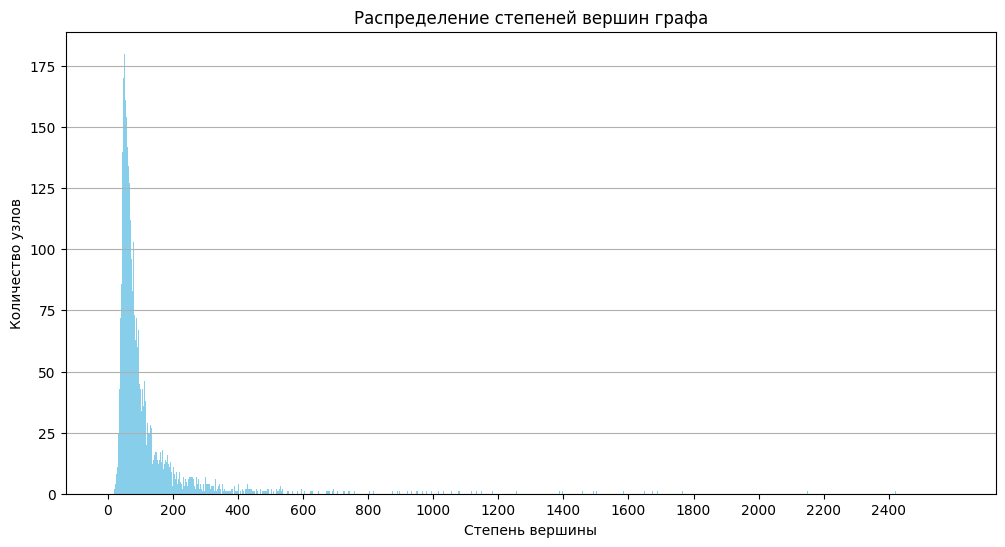

In [39]:
degree_list = G.degree()
nodes = [node for node, degree in degree_list]
degrees = [degree for node, degree in degree_list]

degree_df = pd.DataFrame({'node': nodes, 'degree': degrees})

plt.figure(figsize=(12, 6))
plt.hist(degrees, bins=range(1, max(degrees) + 1), align='left', color='skyblue')
plt.title("Распределение степеней вершин графа")
plt.xlabel("Степень вершины")
plt.ylabel("Количество узлов")
x_ticks = range(0, max(degrees), 200)
plt.xticks(x_ticks)
plt.grid(axis='y')

plt.show()

### Оценка зависимости целевого признака (уровня экспрессии белка) и количества связей

In [40]:
train_degree_data = train.merge(degree_df, how='left')

test_degree_data = test.merge(degree_df, how='left')

print('Пример датасета train')
display(train_degree_data.head())

print('Пример датасета test')
display(test_degree_data.head())

Пример датасета train


,target,node,degree
0,0.251968,11142,50
1,0.689541,2243,190
2,0.678245,15514,172
3,0.272500,20944,61
4,0.248888,8721,62


Пример датасета test


,target,node,degree
0,0.279231,817,70
1,0.380795,9574,92
2,0.686527,1607,176
3,0.303594,4782,83
4,0.367374,24125,79


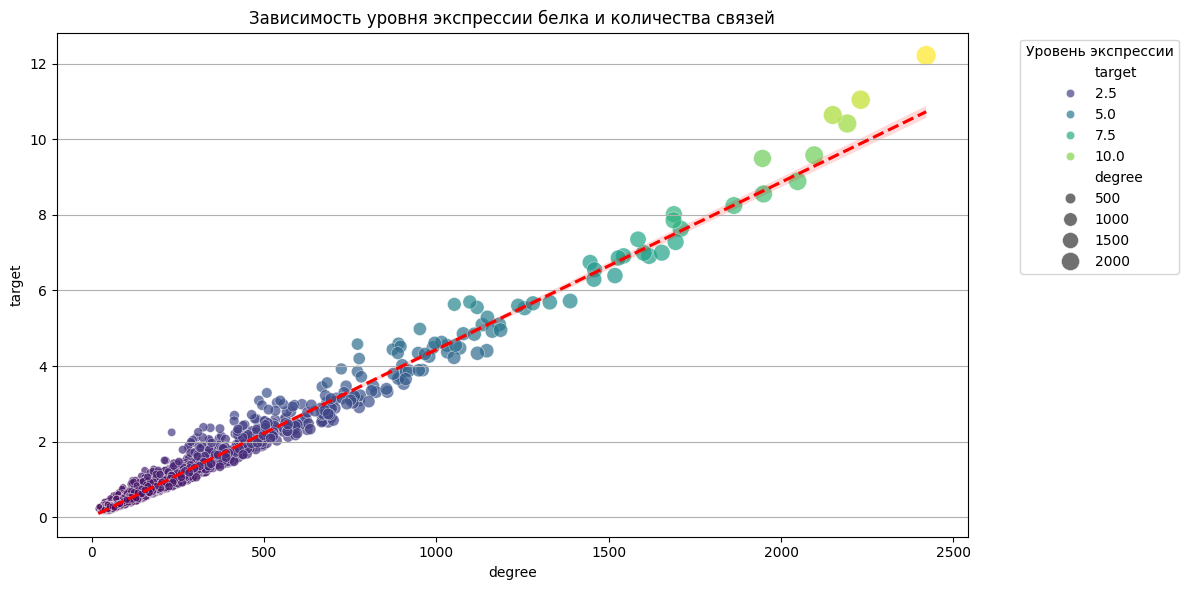

In [41]:
# Построение графика
plt.figure(figsize=(12, 6))

sns.scatterplot(data=train_degree_data, x='degree', y='target', hue='target', size='degree', sizes=(20, 200), palette='viridis', alpha=0.7, edgecolor='w')

plt.title("Зависимость уровня экспрессии белка и количества связей")
plt.xlabel("Количество связей")
plt.ylabel("Уровень экспрессии белка")
plt.grid(axis='y')

# Добавление линии регрессии
sns.regplot(data=train_degree_data, x='degree', y='target', scatter=False, color='red', line_kws={"linestyle":"--"})

plt.legend(title='Уровень экспрессии', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Шаг 6: Показать график
plt.show()

На графике видна прямая линейная корреляция количества связей и уровня экспрессии.

## Построение модели предсказания уровня белка для тестовой выборки

### Linear Regression

In [42]:
X_train = train_degree_data['degree'].values.reshape(-1, 1)
y_train = train_degree_data['target'].values

X_test = test_degree_data['degree'].values.reshape(-1, 1)
y_test = test_degree_data['target'].values

#Создание и обучение модели
model = LinearRegression()
model.fit(X_train, y_train)

print(f'Коэффициент линейной регрессии: {round(model.coef_[0], 4)}, свободный член регрессии: {round(model.intercept_, 4)}')

#Предсказание значений на тестовой выборке
y_pred= model.predict(X_test)

#Оценка качества модели
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Средняя абсолютная ошибка (MAE): {round(mae,4)}')
print(f'Корень из MSE: {round(rmse, 4)}')
print(f'Доля объясненной дисперсии:{round(r2,4)}')

test_degree_data['pred'] = y_pred
test_degree_data.head()

Коэффициент линейной регрессии: 0.0044, свободный член регрессии: 0.013
Средняя абсолютная ошибка (MAE): 0.0637
Корень из MSE: 0.1293
Доля объясненной дисперсии:0.9778


,target,node,degree,pred
0,0.279231,817,70,0.322772
1,0.380795,9574,92,0.420143
2,0.686527,1607,176,0.791923
3,0.303594,4782,83,0.380310
4,0.367374,24125,79,0.362606


### Random Forest Regression

In [43]:
X_train = train_degree_data['degree'].values.reshape(-1, 1)
y_train = train_degree_data['target'].values

X_test = test_degree_data['degree'].values.reshape(-1, 1)
y_test = test_degree_data['target'].values

#Создание и обучение модели
model = RandomForestRegressor()
model.fit(X_train, y_train)

#Предсказание значений на тестовой выборке
y_pred= model.predict(X_test)

#Оценка качества модели
rmse_rf = root_mean_squared_error(y_test, y_pred)
mae_rf = mean_absolute_error(y_test, y_pred)
r2_rf = r2_score(y_test, y_pred)

print(f'Средняя абсолютная ошибка (MAE): {round(mae_rf,4)}')
print(f'Корень из MSE: {round(rmse_rf, 4)}')
print(f'Доля объясненной дисперсии:{round(r2_rf,4)}')

test_degree_data['pred'] = y_pred
test_degree_data.head()

Средняя абсолютная ошибка (MAE): 0.0627
Корень из MSE: 0.1365
Доля объясненной дисперсии:0.9752


,target,node,degree,pred
0,0.279231,817,70,0.317308
1,0.380795,9574,92,0.403924
2,0.686527,1607,176,0.770615
3,0.303594,4782,83,0.365613
4,0.367374,24125,79,0.352655


### Обогащение модели другими признаками

Библиотека networkx очень медленно обрабатывает имеющийся граф. Для дальнейшей работы будем использовать библиотеку igraph. Для уточнения результата предсказания добавим в модель другие признаки графа:
- Closeness (мера центральности в сети, которая вычисляется как сумма длин кратчайших путей между узлом и всеми другими узлами графа)
- Betweenness (мера в графах, которая показывает, насколько часто рассматриваемая вершина является «перевалочным пунктом» при переходах от одной вершины графа до любой другой)
- Clustering_coefficient (степень взаимодействия между собой ближайших соседей узла, то есть вероятность того, что ближайшие соседи узла будут связаны не только с ним, но и между собой)

In [44]:
g = ig.Graph.from_networkx(G)
#print(g)
print(G)
g = ig.Graph.DataFrame(edges, directed=False)

nodes = list(G.nodes())
g.vs['name'] = nodes

features = pd.DataFrame()

features['node'] = nodes
features['degree'] = g.degree(nodes)
features['closeness'] = g.closeness(nodes)
features['betweenness'] = g.betweenness(nodes)
features['clustering_coefficient'] = g.transitivity_local_undirected(nodes)  # Для неориентированных графов

# Отображение результатов
display(features.head())

Graph with 10000 nodes and 594174 edges


,node,degree,closeness,betweenness,clustering_coefficient
0,344,148,0.422970,2873.619211,0.015720
1,50,394,0.503829,33347.632319,0.042947
2,153,1946,0.553746,591465.658162,0.028256
3,532,124,0.465265,3219.856197,0.054812
4,679,337,0.497562,21171.413699,0.047548


In [45]:
train_extended = train.merge(features, how='left')

test_extended = test.merge(features, how='left')

print('Пример датасета train с дополнительными признаками')
display(train_extended.head())

print('Пример датасета test с дополнительными признаками')
display(test_extended.head())

Пример датасета train с дополнительными признаками


,target,node,degree,closeness,betweenness,clustering_coefficient
0,0.251968,11142,50,0.458628,771.329982,0.118367
1,0.689541,2243,190,0.481833,6493.880787,0.056475
2,0.678245,15514,172,0.484072,5308.655624,0.063171
3,0.272500,20944,61,0.432763,738.986041,0.053552
4,0.248888,8721,62,0.427948,1304.434478,0.052882


Пример датасета test с дополнительными признаками


,target,node,degree,closeness,betweenness,clustering_coefficient
0,0.279231,817,70,0.416694,729.408206,0.025259
1,0.380795,9574,92,0.464098,1712.753147,0.048017
2,0.686527,1607,176,0.463625,4181.056116,0.020455
3,0.303594,4782,83,0.465286,1724.773397,0.062298
4,0.367374,24125,79,0.422541,1343.849707,0.014930


### Предсказание на расширенном датасете с помощью Random Forest

In [46]:
train_extended.columns

Index(['target', 'node', 'degree', 'closeness', 'betweenness',
       'clustering_coefficient'],
      dtype='object')

In [47]:
X_train_extended = train_extended[['degree', 'closeness', 'betweenness', 'clustering_coefficient']]
y_train_extended = train_extended['target']

X_test_extended = test_extended[['degree', 'closeness', 'betweenness', 'clustering_coefficient']]
y_test_extended = test_extended['target']

# Шкалирование не улучшило результат
# scaler = StandardScaler()
# X_train_extended = scaler.fit_transform(X_train_extended)
# X_test_extended_scaled = scaler.transform(X_test_extended)

#Создание и обучение модели
model = RandomForestRegressor()
model.fit(X_train_extended, y_train_extended)

#Предсказание значений на тестовой выборке
y_pred_extended = model.predict(X_test_extended)

#Оценка качества модели
rmse_ext = root_mean_squared_error(y_test_extended, y_pred_extended)
mae_ext = mean_absolute_error(y_test_extended, y_pred_extended)
r2_ext = r2_score(y_test_extended, y_pred_extended)

print(f'Средняя абсолютная ошибка (MAE) для расширенного датасета с Random Forest: {round(mae_ext,4)}')
print(f'Корень из MSE для расширенного датасета с Random Forest: {round(rmse_ext, 4)}')
print(f'Доля объясненной дисперсии для расширенного датасета с Random Forest:{round(r2_ext,4)}')

test_extended['pred'] = y_pred_extended
test_extended.head()

Средняя абсолютная ошибка (MAE) для расширенного датасета с Random Forest: 0.0547
Корень из MSE для расширенного датасета с Random Forest: 0.122
Доля объясненной дисперсии для расширенного датасета с Random Forest:0.9802


,target,node,degree,closeness,betweenness,clustering_coefficient,pred
0,0.279231,817,70,0.416694,729.408206,0.025259,0.331671
1,0.380795,9574,92,0.464098,1712.753147,0.048017,0.403703
2,0.686527,1607,176,0.463625,4181.056116,0.020455,0.763211
3,0.303594,4782,83,0.465286,1724.773397,0.062298,0.341980
4,0.367374,24125,79,0.422541,1343.849707,0.014930,0.372001


In [48]:
importances = model.feature_importances_
feature_names = X_train_extended.columns

importance_df = pd.DataFrame({'Признак': feature_names, 'Важность признака, %': importances*100}).sort_values(by='Важность признака, %', ascending=False)
display(importance_df)

,Признак,"Важность признака, %"
0,degree,80.195795
2,betweenness,13.371207
1,closeness,5.895376
3,clustering_coefficient,0.537622


### Предсказание на расширенном датасете с помощью Linear Regression

In [49]:
#Создание и обучение модели
model = LinearRegression()
model.fit(X_train_extended, y_train_extended)

#Предсказание значений на тестовой выборке
y_pred_extended = model.predict(X_test_extended)

#Оценка качества модели
rmse_ext_lr = root_mean_squared_error(y_test_extended, y_pred_extended)
mae_ext_lr = mean_absolute_error(y_test_extended, y_pred_extended)
r2_ext_lr = r2_score(y_test_extended, y_pred_extended)

print(f'Средняя абсолютная ошибка (MAE) для расширенного датасета с Linear Regression: {round(mae_ext_lr,4)}')
print(f'Корень из MSE для расширенного датасета с Linear Regression: {round(rmse_ext_lr, 4)}')
print(f'Доля объясненной дисперсии для расширенного датасета с Linear Regression:{round(r2_ext_lr,4)}')

test_extended['pred'] = y_pred_extended
test_extended.head()

Средняя абсолютная ошибка (MAE) для расширенного датасета с Linear Regression: 0.056
Корень из MSE для расширенного датасета с Linear Regression: 0.1064
Доля объясненной дисперсии для расширенного датасета с Linear Regression:0.9849


,target,node,degree,closeness,betweenness,clustering_coefficient,pred
0,0.279231,817,70,0.416694,729.408206,0.025259,0.348368
1,0.380795,9574,92,0.464098,1712.753147,0.048017,0.412471
2,0.686527,1607,176,0.463625,4181.056116,0.020455,0.774022
3,0.303594,4782,83,0.465286,1724.773397,0.062298,0.368439
4,0.367374,24125,79,0.422541,1343.849707,0.014930,0.389354


In [50]:
# Шаг 4: Получение коэффициентов
coefficients = model.coef_
intercept = model.intercept_

# Шаг 5: Вывод результатов
feature_names = X_train_extended.columns
importance_df = pd.DataFrame({
    'Признак': feature_names,
    'Коэффициент регрессии': coefficients
})
display(importance_df)

,Признак,Коэффициент регрессии
0,degree,0.004080
1,closeness,-0.353250
2,betweenness,0.000002
3,clustering_coefficient,-0.484648


## Итоги исследования

In [51]:
result = pd.DataFrame()
result['Метрика'] = ['MAE', 'RMSE', 'R2']
result['Random Forest Regression'] = [mae_rf, rmse_rf, r2_rf]
result['Linear Regression'] = [mae, rmse, r2]
result['RF extended features'] = [mae_ext, rmse_ext, r2_ext]
result['LR extended features'] = [mae_ext_lr, rmse_ext_lr, r2_ext_lr]

display(result.round(3))

,Метрика,Random Forest Regression,Linear Regression,RF extended features,LR extended features
0,MAE,0.063,0.064,0.055,0.056
1,RMSE,0.137,0.129,0.122,0.106
2,R2,0.975,0.978,0.980,0.985


Сравнение метрик показывает, что лучше всего отрабатывает предсказание **модель линейной регрессии с дополнительными признаками**. При этом, судя по коэффициентам регрессии, degree стал не самым важным признаком для модели.